In [1]:
import datetime
import os
import pickle
import sys
sys.path.append("../")

import contextily as cx
from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import pandas as pd
import seaborn as sns

from obt import data_utils, gps_utils, plot_utils

### GPS Points

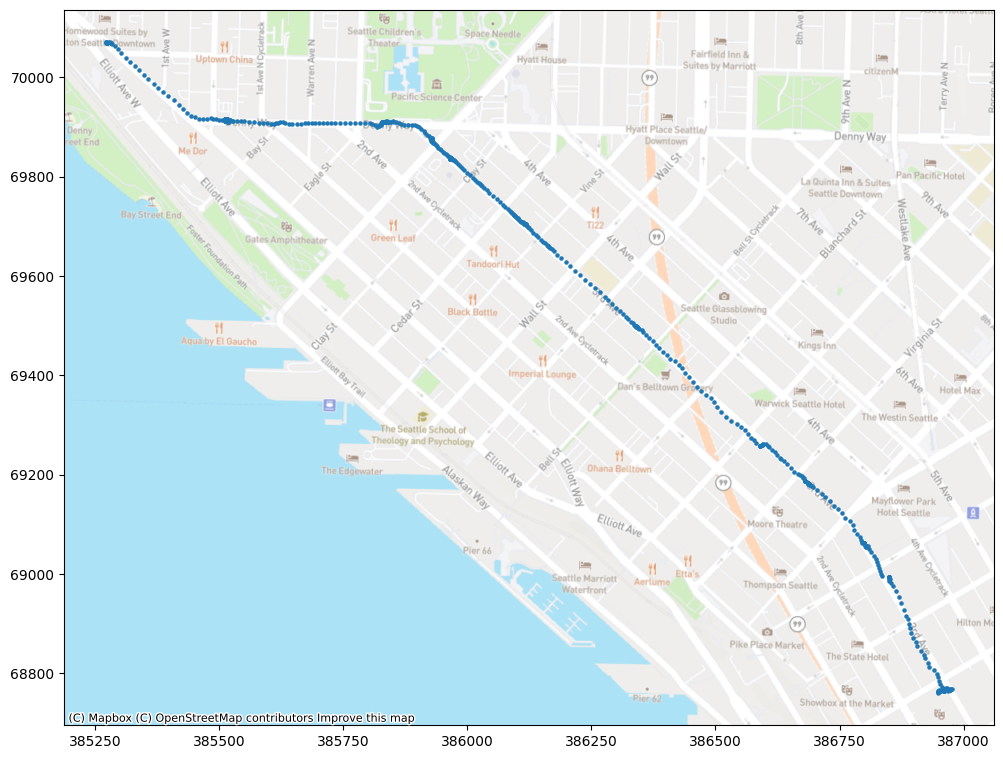

In [2]:
data_phone = pd.read_csv("../data/kcm_validation_sensor/8124-33-2022-10-17_20-52-26/Location.csv")
short_name, veh_id = str.split(pd.read_csv("../data/kcm_validation_sensor/8124-33-2022-10-17_20-52-26/Annotation.csv").iloc[0].text,"-")
data_phone = gpd.GeoDataFrame(data_phone, geometry=gpd.points_from_xy(data_phone.longitude, data_phone.latitude), crs="EPSG:4326").to_crs("EPSG:32148")
_, _, data_phone['calc_speed_m_s'] = gps_utils.calculate_speed(data_phone, 'seconds_elapsed')
plot_utils.formatted_basemap_scatterplot(data_phone, "Phone Basemap")

Filtered down to 140 possible trip_ids; returning the first one (473765543).


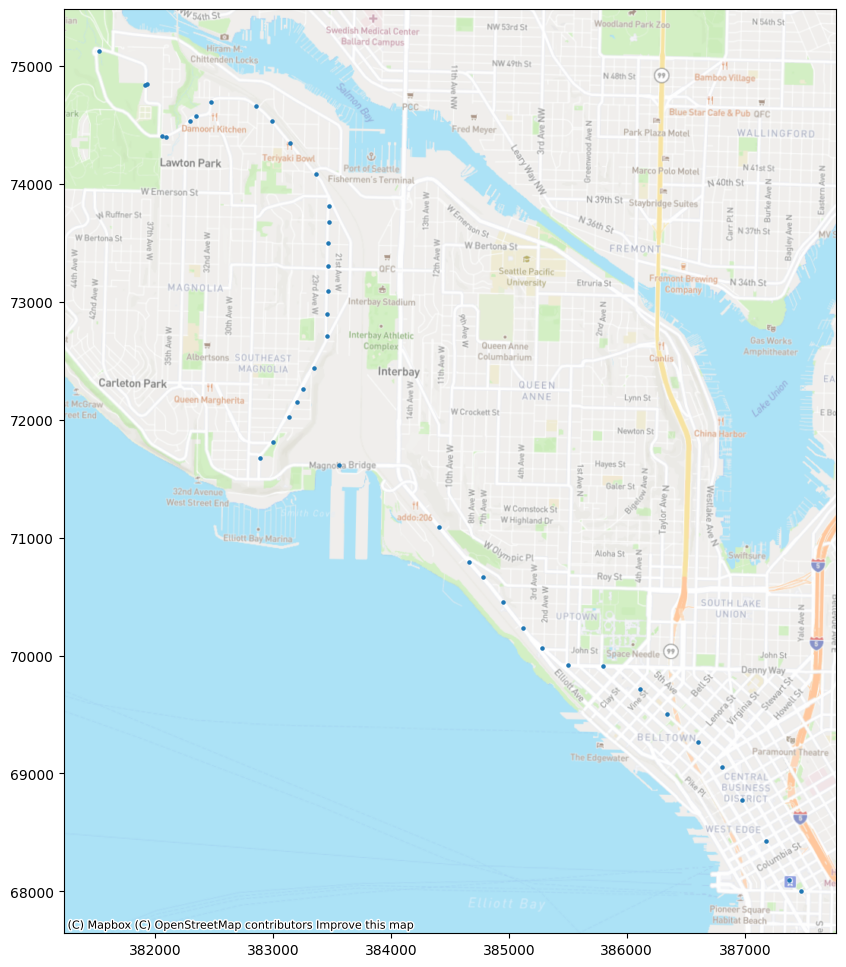

In [3]:
data_gtfs = data_utils.merge_gtfs_files("../data/kcm_gtfs/2023_05_14/", epsg="32148", coord_ref_center=[386910,69022])
gtfs_calendar = pd.read_csv("../data/kcm_gtfs/2023_05_14/calendar.txt")
filtered_gtfs, remaining_trip_ids = data_utils.filter_gtfs_w_phone(data_phone, data_gtfs, short_name, gtfs_calendar)
filtered_gtfs = gpd.GeoDataFrame(filtered_gtfs, geometry=gpd.points_from_xy(filtered_gtfs.stop_lon, filtered_gtfs.stop_lat), crs="EPSG:4326").to_crs("EPSG:32148")
_, _, filtered_gtfs['calc_speed_m_s'] = gps_utils.calculate_speed(filtered_gtfs, 'arrival_s')
plot_utils.formatted_basemap_scatterplot(filtered_gtfs, "GTFS Basemap")

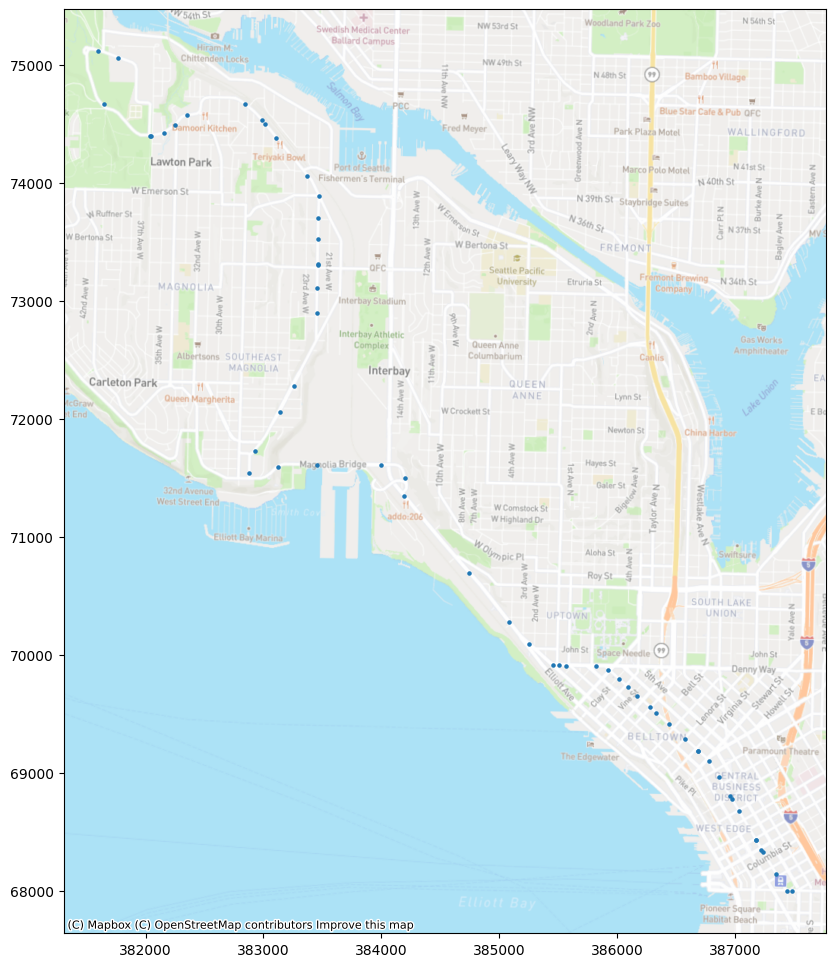

In [4]:
data_gtfsrt = pd.read_pickle("../data/kcm_realtime/2023_05_20.pkl")
data_gtfsrt['locationtime'] = pd.to_numeric(data_gtfsrt['locationtime'])
filtered_gtfsrt_daily = data_gtfsrt[data_gtfsrt['trip_id'].isin(remaining_trip_ids)]
filtered_gtfsrt_one = filtered_gtfsrt_daily[filtered_gtfsrt_daily['trip_id']==remaining_trip_ids[0]]
filtered_gtfsrt_one = gpd.GeoDataFrame(filtered_gtfsrt_one, geometry=gpd.points_from_xy(filtered_gtfsrt_one.lon, filtered_gtfsrt_one.lat), crs="EPSG:4326").to_crs("EPSG:32148")
_, _, filtered_gtfsrt_one['calc_speed_m_s'] = gps_utils.calculate_speed(filtered_gtfsrt_one, 'locationtime')
plot_utils.formatted_basemap_scatterplot(filtered_gtfsrt_one, "GTFS-RT Basemap One Trip")

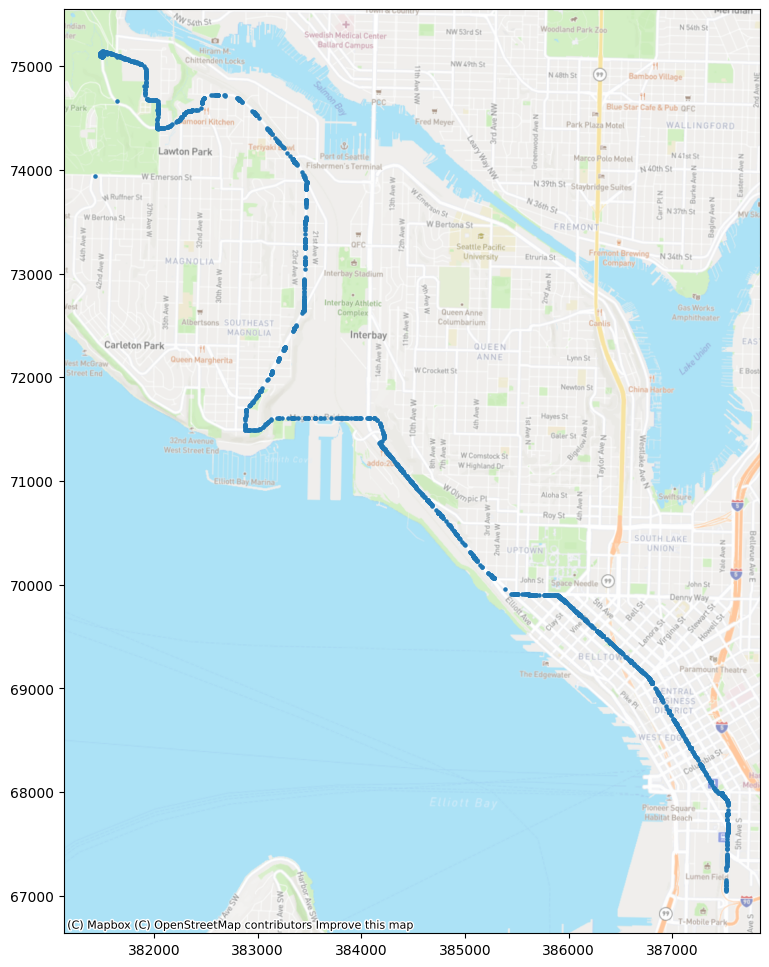

In [5]:
filtered_gtfsrt_daily = gpd.GeoDataFrame(filtered_gtfsrt_daily, geometry=gpd.points_from_xy(filtered_gtfsrt_daily.lon, filtered_gtfsrt_daily.lat), crs="EPSG:4326").to_crs("EPSG:32148")
_, _, filtered_gtfsrt_daily['calc_speed_m_s'] = gps_utils.calculate_speed(filtered_gtfsrt_daily, 'locationtime')
plot_utils.formatted_basemap_scatterplot(filtered_gtfsrt_daily, "GTFS-RT Basemap Daily Trips")

### Drive Cycles

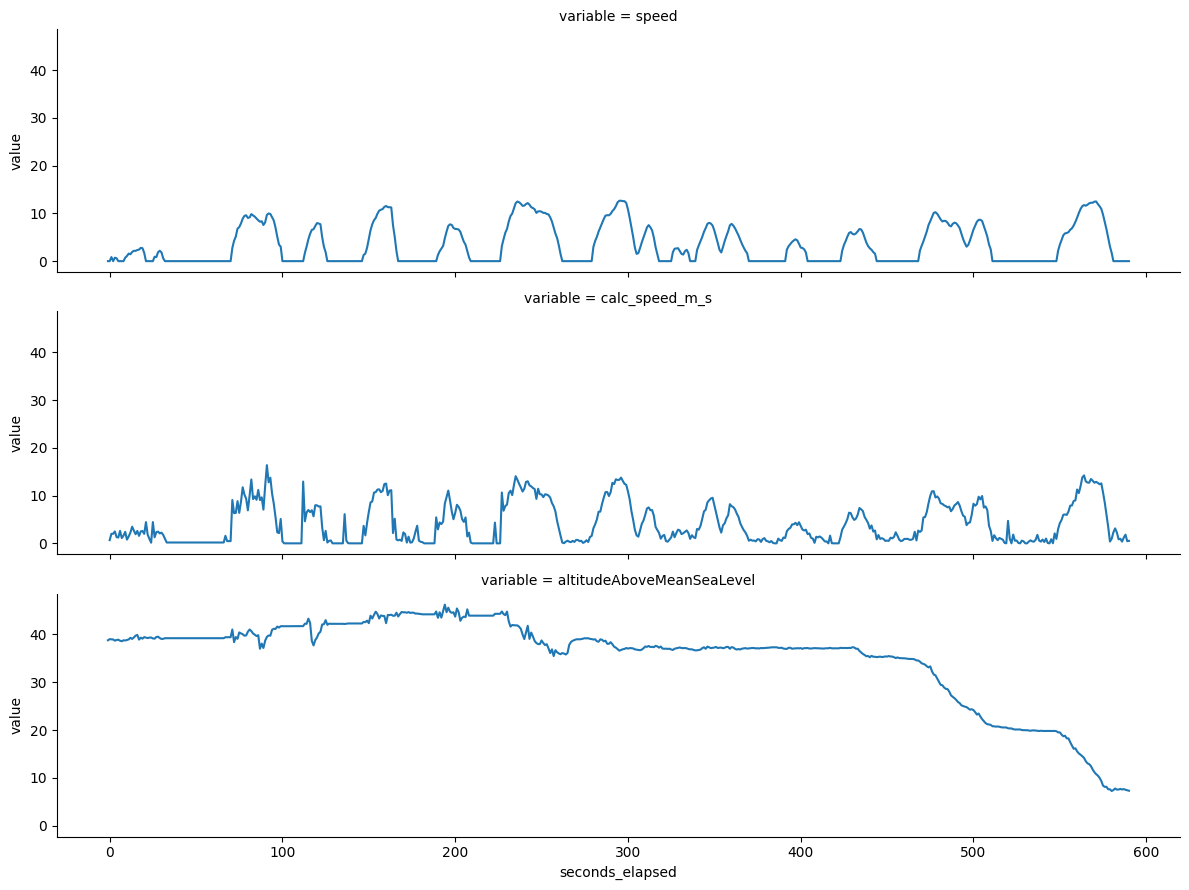

In [6]:
data_melt_phone = pd.melt(data_phone, id_vars=['seconds_elapsed'], value_vars=['speed','calc_speed_m_s','altitudeAboveMeanSeaLevel'])
plot_utils.formatted_rel_lineplot(data_melt_phone, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='Phone Speed')

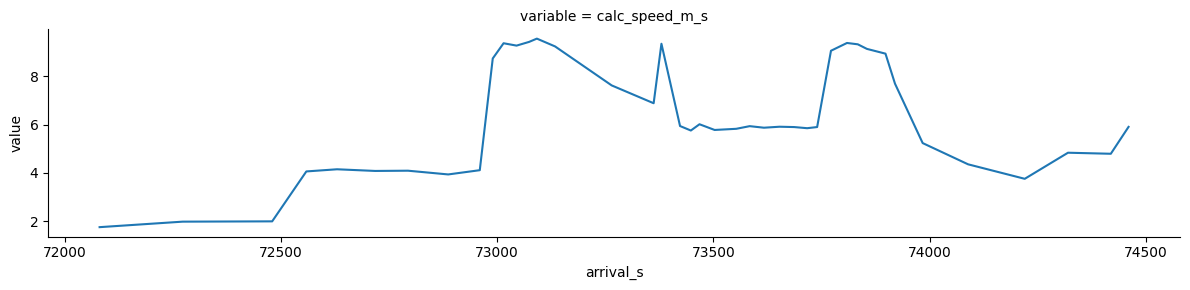

In [7]:
filtered_melt_gtfs = pd.melt(filtered_gtfs, id_vars=['arrival_s'], value_vars=['calc_speed_m_s'])
plot_utils.formatted_rel_lineplot(filtered_melt_gtfs, x_var='arrival_s', y_var='value', rel_var='variable', title_text='GTFS Speed')

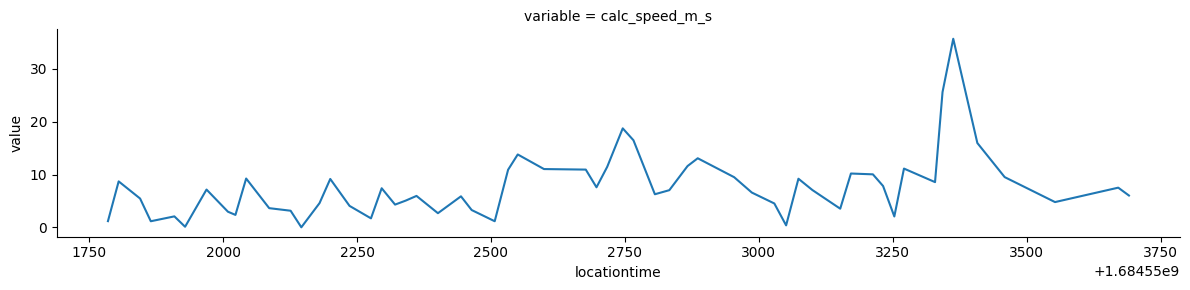

In [8]:
filtered_melt_gtfsrt_one = pd.melt(filtered_gtfsrt_one, id_vars=['locationtime'], value_vars=['calc_speed_m_s'])
plot_utils.formatted_rel_lineplot(filtered_melt_gtfsrt_one, x_var='locationtime', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle One Trip')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


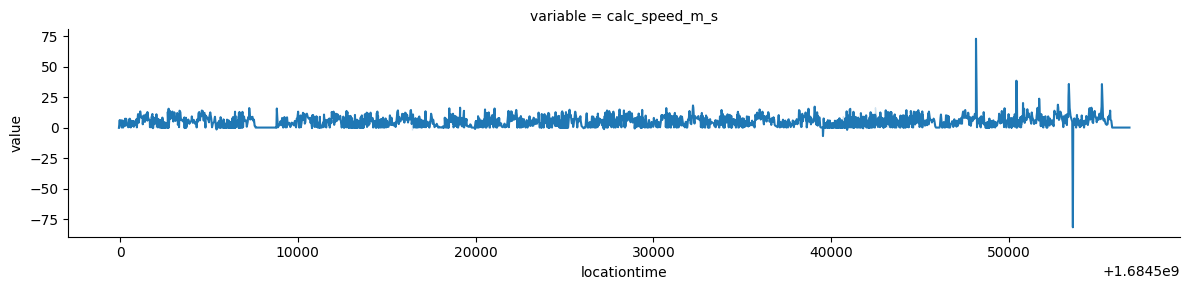

In [9]:
filtered_melt_gtfsrt_daily = pd.melt(filtered_gtfsrt_daily, id_vars=['locationtime'], value_vars=['calc_speed_m_s'])
plot_utils.formatted_rel_lineplot(filtered_melt_gtfsrt_daily, x_var='locationtime', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle Daily Trips')